In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import json
from torch.nn.utils.rnn import pad_sequence
import random 
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use your GPU.")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}") # Prints the name of the first GPU
else:
    print("CUDA is not available. PyTorch will run on CPU.")

CUDA is available. PyTorch can use your GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 4070 Laptop GPU


In [2]:
class TrajectoryDataset(Dataset):

    def __init__(self, json_file):

        with open(json_file, 'r') as f:
            self.data_dict = json.load(f)
        
        self.data = self.data_dict['data']
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        item = self.data[idx]
        
        goal = np.array([
            item['config']['goal']['x'],
            item['config']['goal']['y'],
            item['config']['goal']['z']
        ])
        
        config = goal # Label, Shape (3, )
        
        waypoints = []
        for wp in item['trajectory']['waypoints']:
            waypoints.append([
                wp['x'], wp['y'], wp['z'],
                wp['qx'], wp['qy'], wp['qz'], wp['qw']
            ])
        trajectory = np.array(waypoints)  # Output Data, Shape: (seq_len, 7)
        
        return torch.FloatTensor(config), torch.FloatTensor(trajectory)
    

def collate_pad(batch):
    xs, ys = zip(*batch)                 # tuples
    xs = torch.stack(xs, dim=0)          # [B, 3]

    
    lengths = torch.tensor([y.size(0) for y in ys], dtype=torch.long)
    ys = pad_sequence(ys, batch_first=True) 

    B, T_max, _ = ys.shape

    mask = torch.zeros(B, T_max, dtype=torch.bool)

    for b, L in enumerate(lengths):
        mask[b, :L] = True

    return xs, ys, lengths, mask  

In [3]:
class lstm_trajectory_generator(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size, trans_size, quat_size, hidden_size, num_layers):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_trajectory_generator, self).__init__()

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.translation_linear = nn.Linear(hidden_size, trans_size)

    def forward(self, x_input, encoder_hidden_states):
        
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        
        lstm_out, hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states) 
        translation_pred = self.translation_linear(lstm_out.squeeze(0))
                
        return translation_pred, hidden

In [4]:
def rollout(
    model,
    goal,
    consecutive,
    device='cuda' if torch.cuda.is_available() else 'cpu',
):
    """
    Roll out trajectories for a batch of goals using convergence + proximity
    stopping rules and safety caps.

    Args:
        model: LSTM trajectory generator. Called as model(x_input, hidden),
               where x_input = concat(goal, prev_state_xy) -> (B, 5).
        goal:  (B, 3) tensor of goal positions.
        consecutive: int, number of consecutive small steps required
                     to declare convergence.
        device: torch device.

    Returns:
        pred_traj:  (B, T_used, 2) predicted x,y waypoints.
        lengths:   (B,) tensor of actual lengths for each trajectory
                   (number of valid steps per batch element).
    """
    model.eval()
    goal = goal.to(device)
    B = goal.size(0)

    # Hyperparameters for stopping
    eps_step = 0.001   # [m] step size below which we consider it "not moving"
    eps_goal = 0.02   # [m] distance to goal considered "close enough"
    T_max = 100     # max number of rollout steps
    L_max = 2.0     # [m] max total (signed) path length

    goal_xy = goal[:, :2]  # (B, 2), we only predict x,y for now

    # Storage
    pred_traj = torch.zeros(B, T_max, 2, device=device)

    # Per-sample bookkeeping
    lengths = torch.zeros(B, dtype=torch.long, device=device)   # final lengths
    finished = torch.zeros(B, dtype=torch.bool, device=device)   # done mask
    stable_counts = torch.zeros(B, dtype=torch.long, device=device)   # consecutive small-step count
    total_length = torch.zeros(B, device=device)                     # path length so far

    hidden = None
    prev_pos = None
    last_step = 0  # will track how many timesteps we actually used globally

    # Initial "previous state" at t = 0.
    # If your trajectories always start at (0,0), you can set this to zeros.
    prev_state = torch.zeros(B, 2, device=device)

    with torch.no_grad():
        for t in range(T_max):

            # Input to LSTM: concat(goal, prev_state) -> (B, 5)
            x_input = torch.cat([goal, prev_state], dim=-1)   # (B, 5)
            trans_pred, hidden = model(x_input, hidden)       # (B, 2)
            pred_traj[:, t, :] = trans_pred
            last_step = t + 1

            # Step size & path length
            if t > 0:
                step_vec  = trans_pred - prev_pos           # (B, 2)
                step_norm = torch.norm(step_vec, dim=-1)    # (B,)

                # If ANY component of the step is negative, treat it as "backwards"
                # and subtract the norm from total_length instead of adding it.
                moving_backward = (step_vec < 0).any(dim=-1)        # (B,) bool
                signed_step = torch.where(
                    moving_backward,
                    -step_norm,               # subtract
                    step_norm                 # add
                )
                total_length += signed_step

                # Update "stable" counts (small movement)
                is_small_step = step_norm < eps_step
                stable_counts = torch.where(
                    is_small_step,
                    stable_counts + 1,
                    torch.zeros_like(stable_counts),
                )

            else:
                # First step: no previous position yet
                step_norm = torch.zeros(B, device=device)

            # Distance to goal
            dist_to_goal = torch.norm(trans_pred - goal_xy, dim=-1)  # (B,)

            # Termination criteria
            close_enough   = dist_to_goal < eps_goal
            stable_enough  = stable_counts >= consecutive
            converged_good = close_enough | stable_enough

            too_long_path  = total_length > L_max

            # For each element not already finished, see if it should now stop
            newly_done = (~finished) & (converged_good | too_long_path)

            # Set length for newly finished sequences (t is 0-indexed, so length = t+1)
            lengths = torch.where(
                newly_done & (lengths == 0),
                torch.full_like(lengths, t + 1),
                lengths,
            )

            finished = finished | newly_done
            prev_pos = trans_pred
            prev_state = trans_pred  # at inference we always feed back our own prediction

            # If all samples are done, we can stop unrolling early
            if finished.all():
                break

        # For any samples that never met a stopping condition, we
        # treat their length as the number of steps we actually unrolled.
        lengths = torch.where(
            lengths == 0,
            torch.full_like(lengths, last_step),
            lengths,
        )

    # Trim padded trajectory tensor to the actually used global horizon
    pred_traj = pred_traj[:, :last_step, :]  # (B, last_step, 2)

    return pred_traj, lengths


In [5]:
def train(model, train_loader, val_loader, 
          epochs, learning_rate, tf_ratio, decay_frac,
          device='cuda' if torch.cuda.is_available() else 'cpu'):
    
    model = model.to(device)
    params = model.parameters()
    optimizer = optim.Adam(params, lr=learning_rate)
    state_loss = nn.MSELoss(reduction='none')

    history = {
        'train_loss': [],
        'val_loss': [],
    }

    # Clamp decay_frac to [0, 1] for safety
    decay_frac = max(0.0, min(decay_frac, 1.0))
    warmup_epochs = max(1, int(epochs * decay_frac))          

    for epoch in range(epochs):

        # --- Epoch-specific teacher forcing ratio ---
        if epoch < warmup_epochs:
            if warmup_epochs > 1:
                # Linear decay from tf_ratio (usually 1.0) down to 0.0
                tf_ratio_epoch = tf_ratio * (1.0 - epoch / (warmup_epochs - 1))
            else:
                tf_ratio_epoch = 0.0
        else:
            # After warmup: fully autoregressive
            tf_ratio_epoch = 0.0
        # -------------------------------------------

        model.train()
        training_loss = 0.0

        for i, batch in enumerate(train_loader):

            goal = batch[0].to(device)        # (B, 3)
            gt_traj = batch[1].to(device)     # (B, T_max, 7)
            gt_lengths = batch[2].to(device)
            gt_mask = batch[3].to(device)
            batch_size, max_traj_len, _ = gt_traj.shape

            optimizer.zero_grad()

            gt_translation = gt_traj[:, :, :2]  # (B, T, 2) - just x, y

            hidden = None

            pred_translations = torch.zeros(batch_size, max_traj_len, 2, device=device)  # (B, T, 2)

            for t in range(max_traj_len):

                # Decide what "previous state" to feed in (x, y)
                if t == 0:
                    # For the first step, just use the ground-truth first state
                    prev_state = gt_translation[:, 0, :]            # (B, 2)
                else:
                    # Teacher forcing vs autoregressive
                    if random.random() < tf_ratio_epoch:
                        # Use ground-truth previous state
                        prev_state = gt_translation[:, t - 1, :]    # (B, 2)
                    else:
                        # Use previous predicted state
                        prev_state = pred_translations[:, t - 1, :] # (B, 2)

                # Input to LSTM: concat(goal, prev_state) -> (B, 5)
                x_input = torch.cat([goal, prev_state], dim=-1)     # (B, 5)

                trans_pred, hidden = model(x_input, hidden)         # model input_size must be 5
                pred_translations[:, t, :] = trans_pred

            # MSE over x, y
            trans_loss = state_loss(pred_translations, gt_translation)  # (B, T, 2)
            trans_loss = trans_loss.mean(-1)  # Average over x, y -> (B, T)

            _, T_max, _ = pred_translations.shape
            time_weights = torch.linspace(1.0, 5.0, steps=T_max, device=device)  # for example
            time_weights = time_weights.unsqueeze(0)  # (1, T_max)
            weighted_loss = trans_loss * time_weights * gt_mask

            loss = weighted_loss.sum() / (time_weights * gt_mask).sum()
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

            # if (epoch+1) % 10 == 0 and i == 0: 
                
            #     # Translation predictions
            #     print("\n=== Translation Predictions vs Ground Truth ===")
                
            #     # Track all errors across the batch
            #     all_batch_errors = []
            #     trajectory_means = []
                
            #     for b in range(batch_size):  # Show first 3 trajectories
            #         valid_length = int(gt_lengths[b].item())
                    
            #         if valid_length > 0:
            #             print(f"\nTrajectory {b} (length={valid_length}):")
            #             print("Step |  Pred (x, y)    |   GT (x, y)     |  Error")
            #             print("-" * 55)
                        
            #             # Track errors for mean calculation
            #             trajectory_errors = []
                        
            #             # Show entire trajectory
            #             for t in range(valid_length):
            #                 pred_x = pred_translations[b, t, 0].item()
            #                 pred_y = pred_translations[b, t, 1].item()
            #                 gt_x = gt_translation[b, t, 0].item()
            #                 gt_y = gt_translation[b, t, 1].item()
                            
            #                 error = (pred_x - gt_x)**2 + (pred_y - gt_y)**2
            #                 trajectory_errors.append(error)
            #                 all_batch_errors.append(error)
                            
            #                 print(f"{t:4d} | ({pred_x:6.3f}, {pred_y:6.3f}) | "
            #                     f"({gt_x:6.3f}, {gt_y:6.3f}) | {error:6.4f}")
                        
            #             # Print mean error for this trajectory
            #             mean_error = sum(trajectory_errors) / len(trajectory_errors)
            #             trajectory_means.append(mean_error)
            #             print("-" * 55)
            #             print(f"Mean trajectory error: {mean_error:6.4f}")
                
            #     # Print both types of batch mean errors
            #     print("=" * 55)
            #     if all_batch_errors:
            #         batch_mean_error = sum(all_batch_errors) / len(all_batch_errors)
            #         print(f"BATCH MEAN ERROR (all timesteps): {batch_mean_error:6.4f}")

            #     if trajectory_means:
            #         mean_of_means = sum(trajectory_means) / len(trajectory_means)
            #         print(f"BATCH MEAN ERROR (mean of means): {mean_of_means:6.4f}")

        average_train_loss = training_loss / len(train_loader)
        history['train_loss'].append(average_train_loss)

        # Validation #
        with torch.no_grad():

            val_loss = 0.0

            for i, batch in enumerate(val_loader):

                goal = batch[0].to(device)   # (B, 3)
                gt_traj = batch[1].to(device)   # (B, T_gt_max, 7)
                gt_lengths = batch[2].to(device)  # (B,)

                batch_size, max_traj_len, _ = gt_traj.shape

                pred_traj, pred_len = rollout(model, goal, consecutive=3, device=device)
                # pred_traj: (B, T_pred_max, 2)
                # pred_len:  (B,)

                # We'll just look at x,y from the GT trajectory
                gt_translation = gt_traj[:, :, :2]

                # === DEBUG PRINTS ===
                # First batch every 25 epochs (mirroring your training logic)
                if (epoch+1) % 10 == 0 and i == 0:

                    print("\n=== [VALIDATION] Translation Predictions vs Ground Truth ===")

                    for b in range(batch_size):
                        gt_L    = int(gt_lengths[b].item())
                        pred_L  = int(pred_len[b].item())
                        max_L   = max(gt_L, pred_L)

                        print(f"\nTrajectory {b} (GT length={gt_L}, Pred length={pred_L}):")
                        print("Step |    Pred (x, y)      |     GT (x, y)       |  Error")
                        print("-" * 70)

                        for t in range(max_L):
                            # Predicted point (if within predicted length)
                            if t < pred_L:
                                pred_x = pred_traj[b, t, 0].item()
                                pred_y = pred_traj[b, t, 1].item()
                                pred_str = f"({pred_x:7.3f}, {pred_y:7.3f})"
                            else:
                                pred_x = pred_y = None
                                pred_str = "      ---           "

                            # Ground-truth point (if within GT length)
                            if t < gt_L:
                                gt_x = gt_translation[b, t, 0].item()
                                gt_y = gt_translation[b, t, 1].item()
                                gt_str = f"({gt_x:7.3f}, {gt_y:7.3f})"
                            else:
                                gt_x = gt_y = None
                                gt_str = "      ---           "

                            # Per-step squared error only if both exist
                            if (pred_x is not None) and (gt_x is not None):
                                err = (pred_x - gt_x)**2 + (pred_y - gt_y)**2
                                err_str = f"{err:7.4f}"
                            else:
                                err_str = "  n/a  "

                            print(f"{t:4d} | {pred_str} | {gt_str} | {err_str}")

                        print("-" * 70)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss = {average_train_loss:.4f}, "
              f"tf_ratio = {tf_ratio_epoch:.3f}")

    return history


In [6]:
dataset = TrajectoryDataset('datasets/goal_input_only_datasets/train/dataset_one_side.json')

N = len(dataset)
train_size = int(0.8 * N)
val_size = int(0.2 * N)

train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size],
)

train_dataloader = DataLoader(
    train_dataset,  
    batch_size=8,
    collate_fn=collate_pad,
    shuffle=True,
    num_workers=0  
)
        
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=8,
    collate_fn=collate_pad,
    shuffle=False,
    num_workers=0
)

model = lstm_trajectory_generator(input_size=5, trans_size=2, quat_size=2, hidden_size=128, num_layers=2)

EPOCHS = 600
history = train(model=model, train_loader=train_dataloader, val_loader=val_dataloader, epochs=EPOCHS, learning_rate=0.01, tf_ratio=0.0, decay_frac=0.1)

Epoch 1/600: Train Loss = 0.3224, tf_ratio = 0.000
Epoch 2/600: Train Loss = 0.1544, tf_ratio = 0.000
Epoch 3/600: Train Loss = 0.1465, tf_ratio = 0.000
Epoch 4/600: Train Loss = 0.1116, tf_ratio = 0.000
Epoch 5/600: Train Loss = 0.0376, tf_ratio = 0.000
Epoch 6/600: Train Loss = 0.0287, tf_ratio = 0.000
Epoch 7/600: Train Loss = 0.0290, tf_ratio = 0.000
Epoch 8/600: Train Loss = 0.0300, tf_ratio = 0.000
Epoch 9/600: Train Loss = 0.0286, tf_ratio = 0.000

=== [VALIDATION] Translation Predictions vs Ground Truth ===

Trajectory 0 (GT length=42, Pred length=61):
Step |    Pred (x, y)      |     GT (x, y)       |  Error
----------------------------------------------------------------------
   0 | ( -0.009,  -0.089) | (  0.000,   0.000) |  0.0079
   1 | ( -0.029,  -0.061) | (  0.005,   0.001) |  0.0050
   2 | ( -0.002,  -0.032) | (  0.020,   0.006) |  0.0019
   3 | (  0.053,   0.013) | (  0.045,   0.013) |  0.0001
   4 | (  0.118,   0.052) | (  0.080,   0.023) |  0.0023
   5 | (  0.184,   

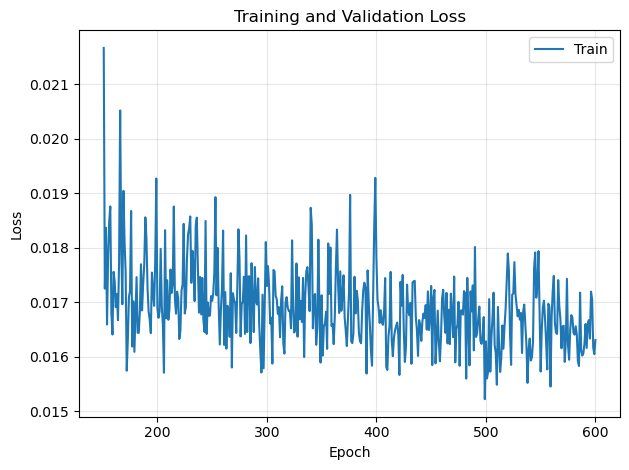

In [7]:
import matplotlib.pyplot as plt

# Lists of 100 floats
train_losses = history['train_loss']
#val_losses = history['val_loss']

train_losses = train_losses[150:]

epochs = range(1, EPOCHS+1)
epochs = epochs[150:]

plt.figure()
plt.plot(epochs, train_losses, label='Train')
#plt.plot(epochs, val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

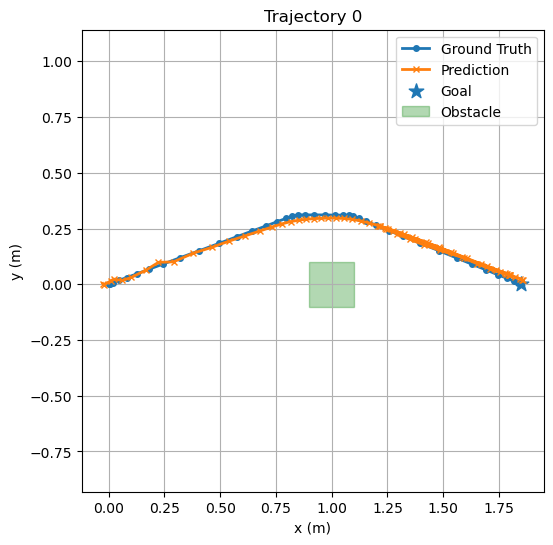

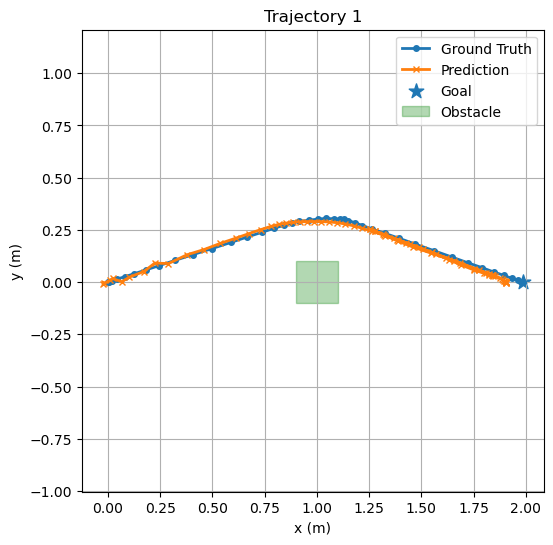

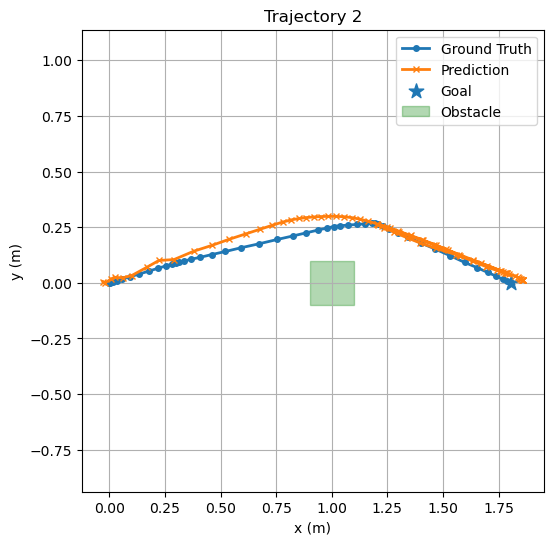

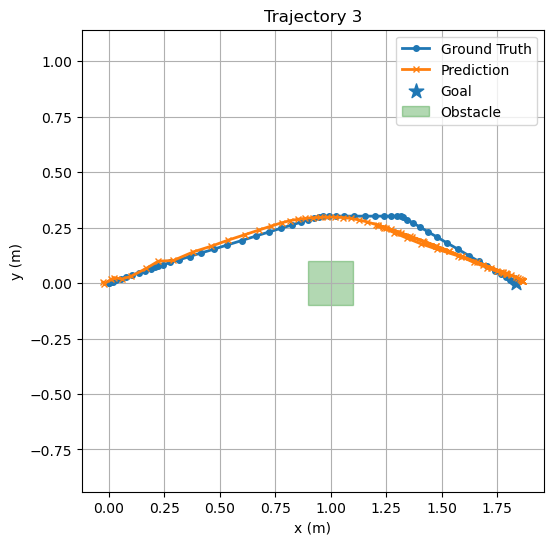

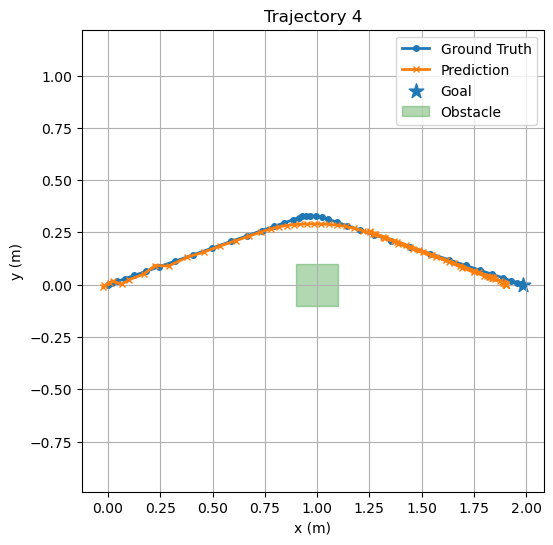

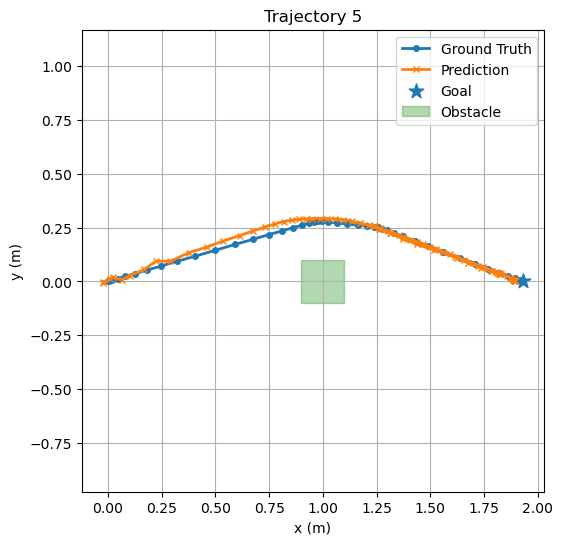

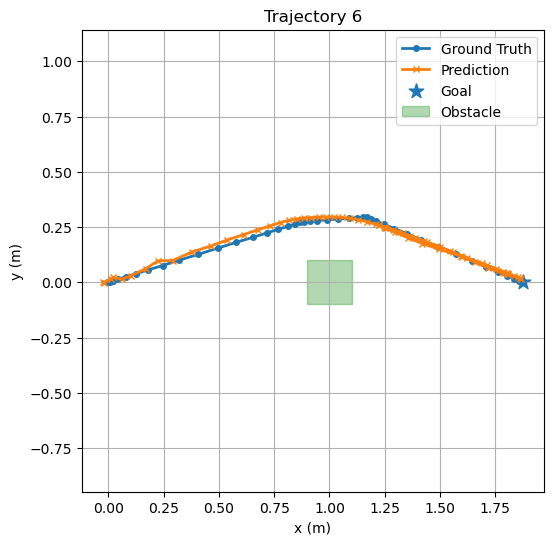

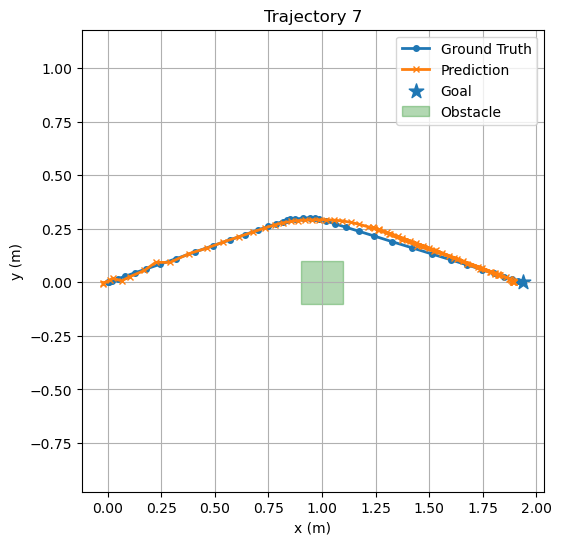

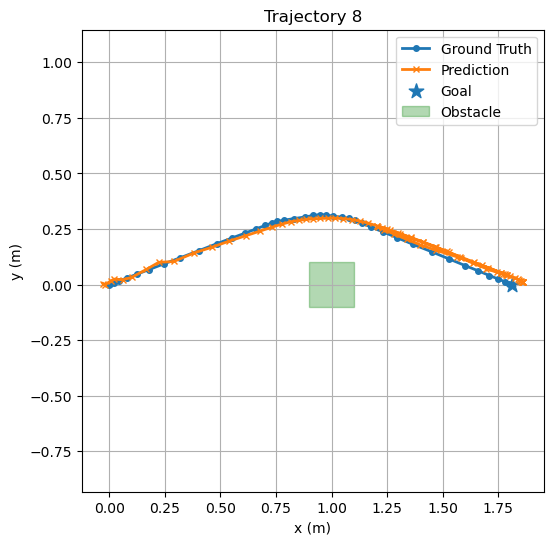

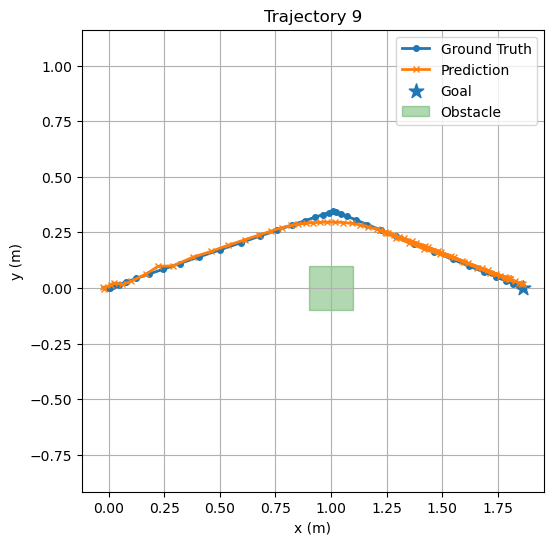

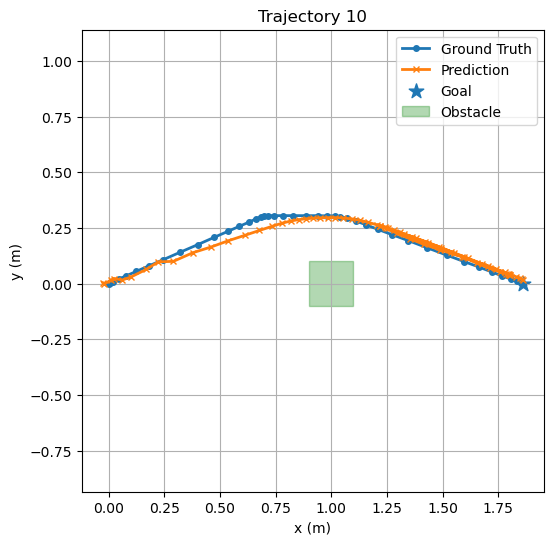

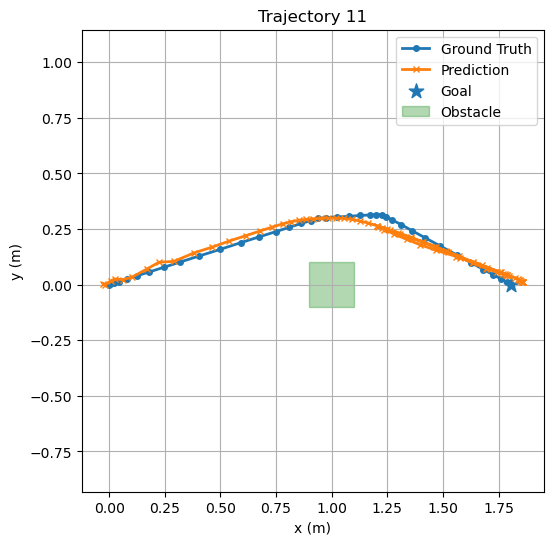

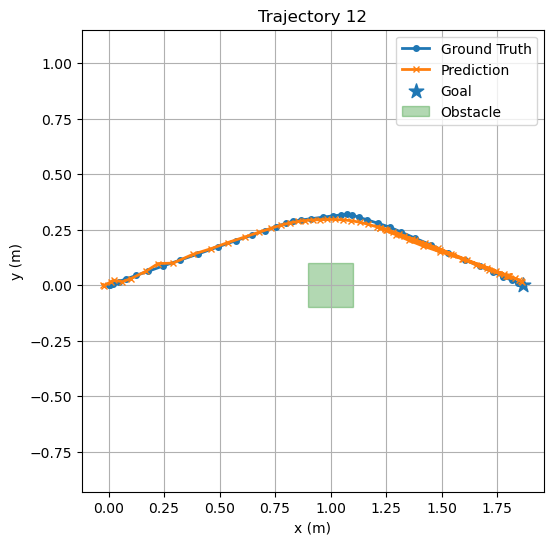

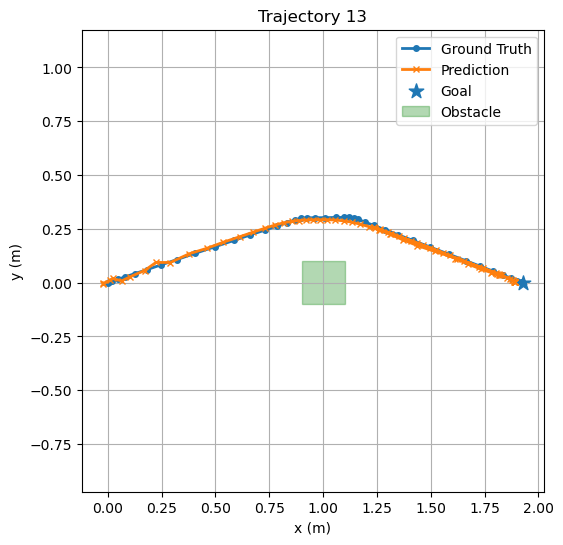

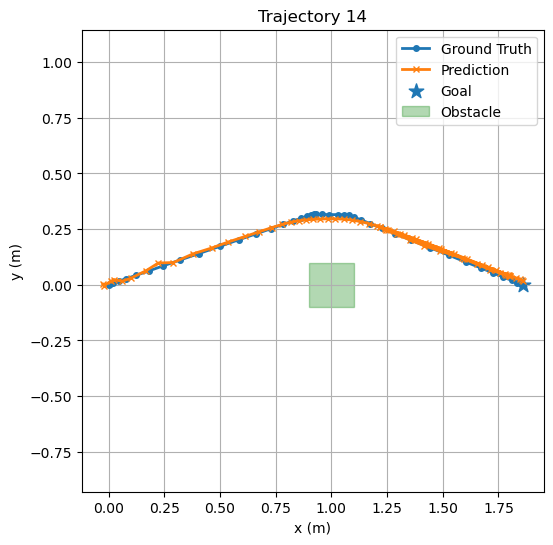

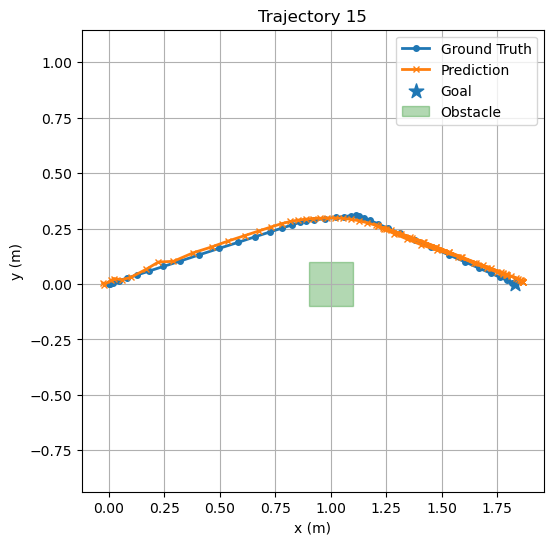

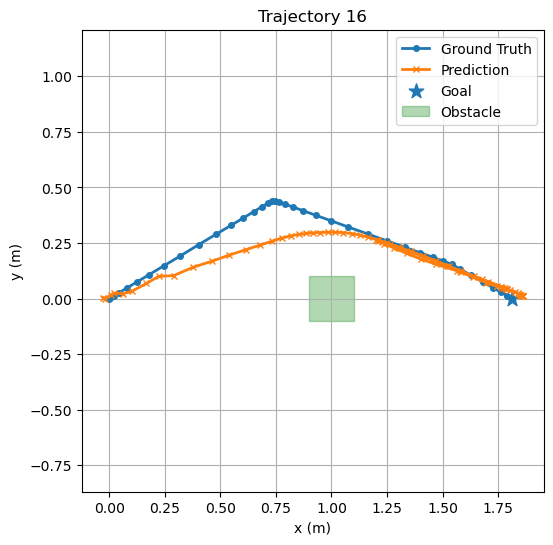

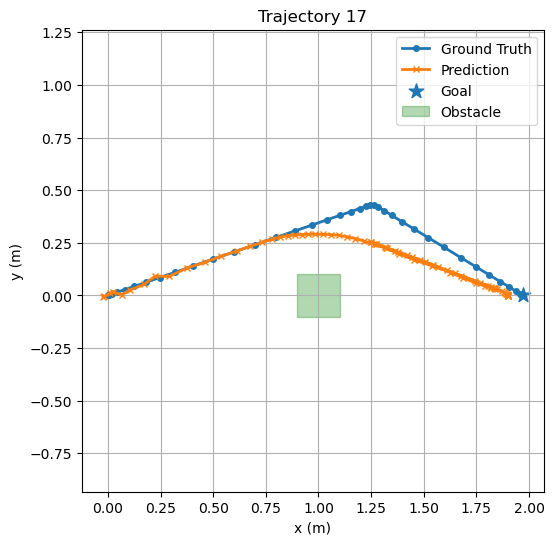

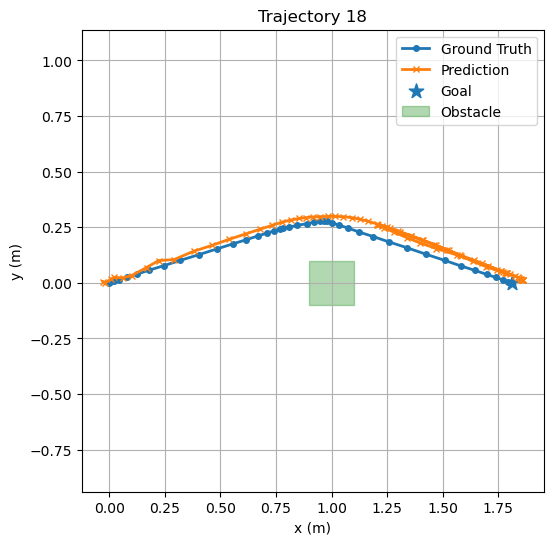

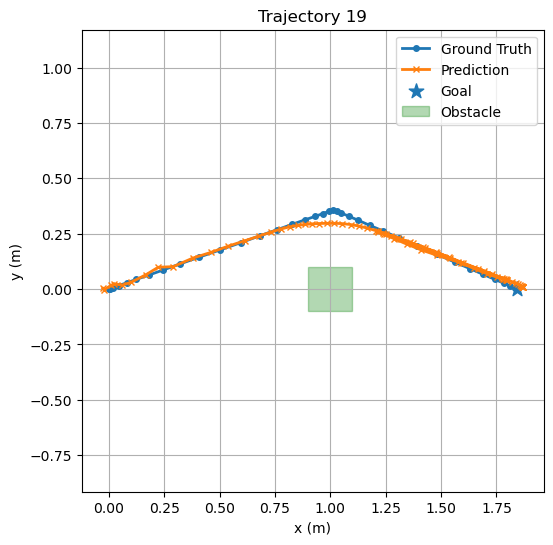

In [13]:
from matplotlib.patches import Rectangle
test_dataset = TrajectoryDataset('datasets/goal_input_only_datasets/test/dataset_one_side_test.json')

test_dataloader = DataLoader(
    test_dataset,  
    collate_fn=collate_pad,
    shuffle=False,
    num_workers=0  
)

# Batch Size is just 1

# Batch Size is just 1

model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    
    for i, batch in enumerate(test_dataloader):

        goal = batch[0].to(device)        # (B, 3)
        gt_traj = batch[1].to(device)     # (B, T_gt_max, 7)
        gt_lengths = batch[2].to(device)  # (B,)

        batch_size, max_traj_len, _ = gt_traj.shape
        assert batch_size == 1, "This plotting code assumes batch_size == 1"

        # Roll out prediction
        pred_traj, pred_len = rollout(model, goal, consecutive=3, device=device)
        # pred_traj: (B, T_pred_max, 2)
        # pred_len:  (B,)

        # We'll just look at x,y from the GT trajectory
        gt_translation = gt_traj[:, :, :2]   # (B, T_gt_max, 2)

        # Extract lengths as ints
        gt_L   = int(gt_lengths[0].item())
        pred_L = int(pred_len[0].item())

        # Slice to the valid parts
        gt_xy   = gt_translation[0, :gt_L, :].detach().cpu().numpy()   # (T_gt, 2)
        pred_xy = pred_traj[0, :pred_L, :].detach().cpu().numpy()      # (T_pred, 2)
        goal_xy = goal[0, :2].detach().cpu().numpy()                   # (2,)

        # --- Plot Prediction and Ground Truth trajectories on (x,y) grid ---
        fig, ax = plt.subplots(figsize=(6, 6))

        # Ground-truth trajectory
        ax.plot(
            gt_xy[:, 0], gt_xy[:, 1],
            '-o', linewidth=2, markersize=4, label='Ground Truth'
        )

        # Predicted trajectory
        ax.plot(
            pred_xy[:, 0], pred_xy[:, 1],
            '-x', linewidth=2, markersize=4, label='Prediction'
        )

        # Mark the goal position
        ax.scatter(
            goal_xy[0], goal_xy[1],
            marker='*', s=120, label='Goal'
        )

        # ---- Draw obstacle as a green square ----
        obstacle_center = (1.0, 0.0)
        side = 0.2
        lower_left = (obstacle_center[0] - side/2, obstacle_center[1] - side/2)

        obstacle_patch = Rectangle(
            lower_left,
            side, side,
            facecolor='green',
            alpha=0.3,
            edgecolor='green',
            label='Obstacle'
        )
        ax.add_patch(obstacle_patch)
        # ----------------------------------------

        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.set_title(f'Trajectory {i}')
        ax.grid(True)

        # --- Make x and y axis have the same numeric span (square view) ---
        import numpy as np

        # Collect all x,y points we care about (GT, pred, goal, obstacle corners)
        all_x = np.concatenate([
            gt_xy[:, 0],
            pred_xy[:, 0],
            np.array([goal_xy[0], obstacle_center[0] - side/2, obstacle_center[0] + side/2])
        ])
        all_y = np.concatenate([
            gt_xy[:, 1],
            pred_xy[:, 1],
            np.array([goal_xy[1], obstacle_center[1] - side/2, obstacle_center[1] + side/2])
        ])

        x_min, x_max = all_x.min(), all_x.max()
        y_min, y_max = all_y.min(), all_y.max()

        x_range = x_max - x_min
        y_range = y_max - y_min
        max_range = max(x_range, y_range)

        # Center the square window around the midpoints
        x_mid = 0.5 * (x_min + x_max)
        y_mid = 0.5 * (y_min + y_max)

        # Add a small margin (10%)
        margin = 0.1 * max_range
        half = 0.5 * (max_range + margin)

        ax.set_xlim(x_mid - half, x_mid + half)
        ax.set_ylim(y_mid - half, y_mid + half)

        # Ensure equal aspect ratio
        ax.set_aspect('equal', adjustable='box')
        # ---------------------------------------------------------------

        ax.legend()
        plt.show()